In [31]:
import pyreadr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
result = pyreadr.read_r("data/atsp_spring.rds")

In [15]:
df = list(result.values())[0]

In [16]:
df.head()

,runID,ts,tsCorrected,sig,sigsd,noise,freq,freqsd,motusTagID,ambigID,...,Sex,Location,BandNumber,Wing,Fat,Mass,Lost,Isotope_value,captureDate,capture.yday
0,253470629,2019-04-18 02:43:52.837699890,1.555573e+09,-69.9975,42.9432,-79.0219,4.2485,0.0276,32463.0,NaN,...,U,OLD CUT,2720-19140,77,4,22.0,0,NaN,2019-02-27,58.0
1,253470629,2019-04-18 02:44:12.536200047,1.555573e+09,-72.4903,61.8822,-80.2089,4.2523,0.0068,32463.0,NaN,...,U,OLD CUT,2720-19140,77,4,22.0,0,NaN,2019-02-27,58.0
2,253470629,2019-04-18 02:44:32.224400043,1.555573e+09,-68.8146,29.5234,-77.9249,4.2648,0.0136,32463.0,NaN,...,U,OLD CUT,2720-19140,77,4,22.0,0,NaN,2019-02-27,58.0
3,253470629,2019-04-18 02:44:51.924200058,1.555573e+09,-69.2750,21.6095,-78.3453,4.2630,0.0089,32463.0,NaN,...,U,OLD CUT,2720-19140,77,4,22.0,0,NaN,2019-02-27,58.0
4,253470629,2019-04-18 02:45:11.622900009,1.555574e+09,-65.2469,24.5274,-78.2161,4.2637,0.0055,32463.0,NaN,...,U,OLD CUT,2720-19140,77,4,22.0,0,NaN,2019-02-27,58.0


In [25]:
df.columns

Index(['runID', 'ts', 'tsCorrected', 'sig', 'sigsd', 'noise', 'freq', 'freqsd',
       'motusTagID', 'ambigID', 'port', 'runLen', 'motusFilter', 'mfgID',
       'tagModel', 'tagLifespan', 'tagBI', 'tagDeployID', 'markerNumber',
       'tagDeployStart', 'tagDeployEnd', 'tagDepLat', 'tagDepLon', 'tagDepAlt',
       'recvDeployLat', 'recvDeployLon', 'recvDeployName', 'antBearing',
       'ts_5min', 'date', 'year', 'yday', 'month', 'day', 'minute', 'hour',
       'sunrise', 'sunset', 'tagYear', 'Age', 'Sex', 'Location', 'BandNumber',
       'Wing', 'Fat', 'Mass', 'Lost', 'Isotope_value', 'captureDate',
       'capture.yday', 'bird_id'],
      dtype='object')

In [26]:
df['ts'] = pd.to_datetime(df['ts'])
df['captureDate'] = pd.to_datetime(df['captureDate'])

In [27]:
df['bird_id'] = df['BandNumber'].astype(str) + "_" + df['motusTagID'].astype(int).astype(str)

In [29]:
df.columns

Index(['runID', 'ts', 'tsCorrected', 'sig', 'sigsd', 'noise', 'freq', 'freqsd',
       'motusTagID', 'ambigID', 'port', 'runLen', 'motusFilter', 'mfgID',
       'tagModel', 'tagLifespan', 'tagBI', 'tagDeployID', 'markerNumber',
       'tagDeployStart', 'tagDeployEnd', 'tagDepLat', 'tagDepLon', 'tagDepAlt',
       'recvDeployLat', 'recvDeployLon', 'recvDeployName', 'antBearing',
       'ts_5min', 'date', 'year', 'yday', 'month', 'day', 'minute', 'hour',
       'sunrise', 'sunset', 'tagYear', 'Age', 'Sex', 'Location', 'BandNumber',
       'Wing', 'Fat', 'Mass', 'Lost', 'Isotope_value', 'captureDate',
       'capture.yday', 'bird_id'],
      dtype='object')

In [28]:
detections_per_day = (
    df.groupby(['bird_id', 'date'])
      .size()
      .reset_index(name='n_detections')
)

In [20]:
detections_per_day

,bird_id,date,n_detections
0,2221-38875_43401,2020-01-17,1705
1,2221-38875_43401,2020-01-18,2988
2,2221-38875_43401,2020-01-19,4337
3,2221-38875_43401,2020-01-20,3432
4,2221-38875_43401,2020-01-21,3318
...,...,...,...
2941,UNK2_43376,2020-03-27,975
2942,UNK2_43376,2020-03-28,2007
2943,UNK2_43376,2020-03-29,626
2944,UNK2_43376,2020-03-30,48


In [32]:

# Si 'date' es string:
df['date'] = pd.to_datetime(df['date']).dt.date

# Minuto del día (0–1439)
df['minute_of_day'] = df['hour'] * 60 + df['minute']

In [55]:
def plot_day_antennas_full(df, bird_id, day, show_sun=True):
    """
    Muestra TODAS las antenas (estación+port) que detectan a un individuo ese día.
    Cada color = una antena única (receiver + port).
    """
    day = pd.to_datetime(day).date()

    # Filtrar por individuo y día
    d = df[(df['bird_id'] == bird_id) & (df['date'] == day)].copy()
    if d.empty:
        print("No detections for this bird on this date.")
        return

    # Minuto del día
    if 'minute_of_day' not in d.columns:
        d['minute_of_day'] = d['hour'] * 60 + d['minute']

    # === Crear ID único de antena: estacion + port (y opcionalmente bearing) ===
    d['antenna_id'] = (
        d['recvDeployName'].astype(str)
        + " | P" + d['port'].astype(int).astype(str)
        # + " | " + d['antBearing'].astype(int).astype(str) + "°"  # <- si quieres incluir bearing
    )

    antennas = sorted(d['antenna_id'].dropna().unique())

    # Colores para cada antena única
    cmap = plt.cm.get_cmap('tab20', len(antennas))

    plt.figure(figsize=(12, 5))

    for i, ant in enumerate(antennas):
        sub = d[d['antenna_id'] == ant]
        plt.scatter(
            sub['minute_of_day'],
            sub['sig'],
            s=15,
            alpha=0.7,
            label=ant,
            color=cmap(i)
        )

    # Amanecer / atardecer
    if show_sun:
        try:
            sunrise = pd.to_datetime(d['sunrise'].iloc[0])
            sunset  = pd.to_datetime(d['sunset'].iloc[0])
            sr_min = sunrise.hour * 60 + sunrise.minute
            ss_min = sunset.hour * 60 + sunset.minute
            plt.axvline(sr_min, linestyle='--', alpha=0.6)
            plt.axvline(ss_min, linestyle='--', alpha=0.6)
        except Exception as e:
            print("Could not add sunrise/sunset lines:", e)


    plt.gca().invert_yaxis()
    plt.xlim(0, 1440)
    plt.xlabel("Minute of day")
    plt.ylabel("Signal strength (sig)")
    plt.title(f"Signal by antenna for {bird_id} on {day}")


    plt.legend(title="Antenna (station | port)",
               bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.show()


In [46]:
all_ids = sorted(df['bird_id'].dropna().unique())
all_ids[:50]  # ver los primeros 10

['2221-38875_43401',
 '2221-38877_43404',
 '2221-38878_43403',
 '2221-38880_43407',
 '2221-38882_43406',
 '2221-38883_43405',
 '2221-38884_43409',
 '2221-38886_43408',
 '2710-62970_32462',
 '2720-19060_32481',
 '2720-19132_43391',
 '2720-19140_32463',
 '2720-32112_32458',
 '2780-67600_43396',
 '2810-55499_43397',
 '2810-64125_43398',
 '2810-73198_43420',
 '2810-73203_32471',
 '2810-73221_32465',
 '2810-73225_43421',
 '2810-73229_43414',
 '2810-73230_32487',
 '2810-73232_32472',
 '2810-73233_32490',
 '2810-73234_32494',
 '2810-73236_32483',
 '2810-73238_32474',
 '2810-73239_32473',
 '2810-73240_32488',
 '2810-73243_32485',
 '2810-73244_32491',
 '2810-73246_32479',
 '2810-73247_32493',
 '2810-73250_32489',
 '2810-73252_32484',
 '2810-73254_32455',
 '2810-73258_32464',
 '2810-73260_32467',
 '2810-73261_32469',
 '2810-73262_32466',
 '2810-73263_32468',
 '2810-73270_43392',
 '2810-80823_32470',
 '2830-80843_43386',
 '2880-01497_32478',
 '2880-01498_32457',
 '2880-01502_32461',
 '2880-01506_

In [47]:
# Pares únicos (bird_id, date), ordenados
id_date_pairs = (
    df[['bird_id', 'date']]
    .dropna()
    .drop_duplicates()
    .sort_values(['bird_id', 'date'])
)

id_date_pairs

,bird_id,date
350746,2221-38875_43401,2020-01-17
352092,2221-38875_43401,2020-01-18
353654,2221-38875_43401,2020-01-19
355235,2221-38875_43401,2020-01-20
356590,2221-38875_43401,2020-01-21
...,...,...
4490750,UNK2_43376,2020-03-27
4523671,UNK2_43376,2020-03-28
4553469,UNK2_43376,2020-03-29
4578023,UNK2_43376,2020-03-30


C:\Users\jorge\AppData\Local\Temp\ipykernel_31644\497166714.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(antennas))


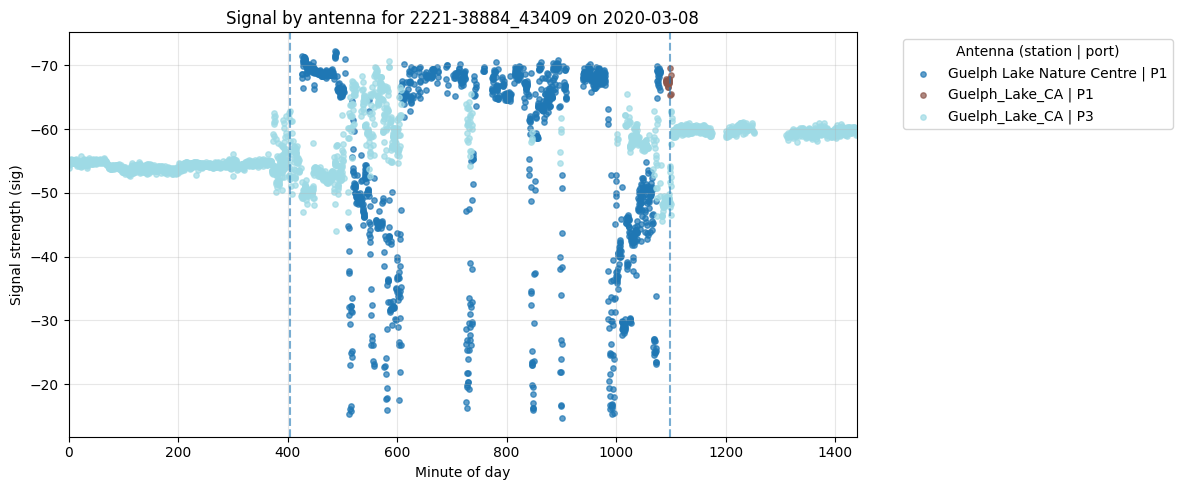

In [75]:
bird = "2221-38884_43409"   # uno real de df['bird_id']
day = "2020-03-08"

plot_day_antennas_full(df, bird, day)

# Testing hipothesis


In [76]:
bird = "2221-38884_43409"
day = pd.to_datetime("2020-03-08").date()

In [80]:
# Filtrar el día y el ave
d = df[(df['bird_id'] == bird) & (df['date'] == day)].copy()

# Crear minuto del día si no existe
if 'minute_of_day' not in d.columns:
    d['minute_of_day'] = d['hour'] * 60 + d['minute']

d['minute_of_day'] = d['hour'] * 60 + d['minute']

In [81]:
# Filtrar el rango de minutos
subset = d[(d['minute_of_day'] >= 1100) & (d['minute_of_day'] <= 1400)]

subset

,runID,ts,tsCorrected,sig,sigsd,noise,freq,freqsd,motusTagID,ambigID,...,BandNumber,Wing,Fat,Mass,Lost,Isotope_value,captureDate,capture.yday,bird_id,minute_of_day
1352044,352725242,2020-03-08 18:20:00.358700037,1.583710e+09,-48.2034,6.3662,-69.1704,3.5257,0.0068,43409.0,NaN,...,2221-38884,75,4,21.4,0,-146.011408,2020-01-31,31.0,2221-38884_43409,1100
1352045,352725244,2020-03-08 18:20:00.358799934,1.583710e+09,-68.4804,13.6377,-75.9329,3.5472,0.0201,43409.0,NaN,...,2221-38884,75,4,21.4,0,-146.011408,2020-01-31,31.0,2221-38884_43409,1100
1352047,352725242,2020-03-08 18:20:19.657399893,1.583710e+09,-46.5727,39.1905,-70.5620,3.5238,0.0037,43409.0,NaN,...,2221-38884,75,4,21.4,0,-146.011408,2020-01-31,31.0,2221-38884_43409,1100
1352048,352725244,2020-03-08 18:20:19.657200098,1.583710e+09,-65.4779,45.5940,-76.3952,3.5432,0.0150,43409.0,NaN,...,2221-38884,75,4,21.4,0,-146.011408,2020-01-31,31.0,2221-38884_43409,1100
1352051,352725242,2020-03-08 18:20:38.957000017,1.583710e+09,-62.8074,9.5710,-72.4371,3.5195,0.0129,43409.0,NaN,...,2221-38884,75,4,21.4,0,-146.011408,2020-01-31,31.0,2221-38884_43409,1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354760,352725299,2020-03-08 23:19:26.473000050,1.583728e+09,-58.8990,18.2245,-67.1215,3.4992,0.0091,43409.0,NaN,...,2221-38884,75,4,21.4,0,-146.011408,2020-01-31,31.0,2221-38884_43409,1399
1354764,352725299,2020-03-08 23:19:45.770999908,1.583728e+09,-59.1977,22.1652,-68.0949,3.5035,0.0173,43409.0,NaN,...,2221-38884,75,4,21.4,0,-146.011408,2020-01-31,31.0,2221-38884_43409,1399
1354768,352725299,2020-03-08 23:20:05.069000006,1.583728e+09,-59.6030,18.2652,-69.0768,3.4897,0.0210,43409.0,NaN,...,2221-38884,75,4,21.4,0,-146.011408,2020-01-31,31.0,2221-38884_43409,1400
1354772,352725299,2020-03-08 23:20:24.366800070,1.583728e+09,-60.0149,14.8866,-68.8789,3.4952,0.0228,43409.0,NaN,...,2221-38884,75,4,21.4,0,-146.011408,2020-01-31,31.0,2221-38884_43409,1400


In [79]:
subset[['ts', 'minute_of_day', 'sig', 'port', 'motusFilter', 'noise', 'sigsd', 'freq', 'freqsd']]


,ts,minute_of_day,sig,port,motusFilter,noise,sigsd,freq,freqsd
1352044,2020-03-08 18:20:00.358700037,1100,-48.2034,3,1.0,-69.1704,6.3662,3.5257,0.0068
1352045,2020-03-08 18:20:00.358799934,1100,-68.4804,1,1.0,-75.9329,13.6377,3.5472,0.0201
1352047,2020-03-08 18:20:19.657399893,1100,-46.5727,3,1.0,-70.5620,39.1905,3.5238,0.0037
1352048,2020-03-08 18:20:19.657200098,1100,-65.4779,1,1.0,-76.3952,45.5940,3.5432,0.0150
1352051,2020-03-08 18:20:38.957000017,1100,-62.8074,3,1.0,-72.4371,9.5710,3.5195,0.0129
...,...,...,...,...,...,...,...,...,...
1354760,2020-03-08 23:19:26.473000050,1399,-58.8990,3,1.0,-67.1215,18.2245,3.4992,0.0091
1354764,2020-03-08 23:19:45.770999908,1399,-59.1977,3,1.0,-68.0949,22.1652,3.5035,0.0173
1354768,2020-03-08 23:20:05.069000006,1400,-59.6030,3,1.0,-69.0768,18.2652,3.4897,0.0210
1354772,2020-03-08 23:20:24.366800070,1400,-60.0149,3,1.0,-68.8789,14.8866,3.4952,0.0228
